In [ ]:
import tensorflow as tf
from pil import Image, Imagechops, ImageEnhance
import os
from pylab import *
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import glob
%matplotlib inline

In [ ]:
def convert_to_ela_image(_filename, _input_path, _output_path, _quality):
    _resaved_filename=_filename.split('.')[0]+'resaved.jpg'
    _ELA_filename=_filename.split('.')[0]+'ela.png'
    
    _im=Image.open(_input_path+filename).convert('L')
    
    _im.save(_output_path+'resaved/'+_resaved_filename, 'JPEG', quality = _quality)
    _resaved_im=Image.open(_output_path+'resaved/'+_resaved_filename)
    
    _ela_im=ImageChops.difference(_im, _resaved_im)
    
    _extrema=_ela_im.getextrema()
    _max_diff=max([ex for ex in _extrema])
    if _max_dff==0:
        max_dff=1
    _scale=255.0/_max_diff
    
    _elasaved_filename=_filename.split('.')[0]+'.elasaved.jpg'
    _ela_im=ImageEnhance.Brightness(_ela_im).enhance(_scale)
    _ela_im.save(_output_path+'ELA/'+_elasaved_filename,'JPEG',quality=_quality)
    return _ela_im

##  학습데이터 생성
## Labeling training data

In [ ]:
input_path='./DATA/INPUT/학습데이터191025/'
output_path='./DATA/TEMP/'

n=np.size(glob.glob(input_path+'*.*'))

# 이미지의 x,y size를 정사각형으로 압축 (256 by 256)
# 임의의 한 데이터로 데이터 저장 배열 크기 알아낸 후, 모든 이미지의 규격이 그와 같다고 가정

# 4:3
# 254 by 237만 쓰는데 나머지는 검은색으로 처리 => 256 by 256
rad_x=24
step_x=9
rad_y=18
step_y=7

X_data=np.zeros(((n,256,256)),dtype=float)
Y_data=np.zeros(((n,2)),dtype=float)

fn_list=[]
fn_except_list=[]
for i in range(n):
    try:
        filename=glob.glob(input_path+'*.*')[i].split('\\')[1]
        fn_list.append(filename.split(',')[0])
        print(i, '파일명: ', input_path+filename)
        raw_data=np.array(convert_to_ela_image(filename,input_path,output_path,90))
        if np.size(raw_data,axis=0)>np.size(raw_data,axis=1):
            x_list=[rad_x+x*step_x for x in range(int((np.size(raw_data,axis=0)-2*rad_x)/step_x))]
            y_list=[rad_y+y*step_y for y in range(int((np.size(raw_data,axis=1)-2*rad_y)/step_y))]
            
            for j,jj in enumerate(x_list):
                for k,kk in enumerate(y_list):
                    X_data[i,j,k]=np.sum(raw_data[jj-rad_x:jj+rad_x+1,kk-rad_y:kk+rad_y+1,:])
            # 0-1 minmax scaling
            X_data[i,:,:]/=np.max(X_data[i,:,:])
        else:
            x_list=[rad_x+x*step_x for x in range(int((np.size(raw_data,axis=1)-2*rad_x)/step_x))]
            y_list=[rad_y+y*step_y for y in range(int((np.size(raw_data,axis=0)-2*rad_y)/step_y))]
            
            for j,jj in enumerate(x_list):
                for k,kk in enumerate(y_list):
                    X_data[i,j,k]=np.sum(raw_data[kk-rad_y:kk+rad_y+1,jj-rad_x:jj+rad_x+1,:])
            # 0-1 minmax scaling
            X_data[i,:,:]/=np.max(X_data[i,:,:])
        if filename.split('_')[0]=='위조':
            Y_data[i][1]=1
        else:
            Y_data[i][0]=1
    except:
        fn_except_list.append(filename.split(',')[0])
        continue

In [ ]:
# 학습데이터 저장
np.save('./DATA/TEMP/ELA_X(tr)1031_plus0.npy',X_data)
np.save('./DATA/TEMP/ELA_Y(tr)1031_plus0.npy',Y_data)

In [ ]:
## 저장된 학습데이터 로드
X_data=np.load('./DATA/TEMP/ELA_X(tr)1031_plus0.npy')
Y_data=np.load('./DATA/TEMP/ELA_Y(tr)1031_plus0.npy')

In [ ]:
randseed=np.random.permutation(len(X_data))
X_data_perm=X_data.copy()[randseed,:,:]
Y_data_perm=Y_data.copy()[randseed,:]
filename_list2=[]
for i in range(len(X_data)):
    temp=filename_list[randseed[i]]
    filename_list2.append(temp)

tr_ratio=0.7

X_tr=X_data_perm[:int(n*tr_ratio),:,:]; X_tst=X_data_perm[int(n*tr_ratio):,:,:]
Y_tr=Y_data_perm[:int(n*tr_ratio),:]; Y_tst=Y_data_perm[int(n*tr_ratio):,:]
filename_list_tr=filename_list2[:int(n*tr_ratio)]
filename_list_tst=filename_list2[int(n*tr_ratio):]

## 모델구조 v1
## Model structure v1

In [ ]:
X=tf.placeholder(tf.float32, [None,256,256,1])
Y=tf.placeholder(tf.float32, [None,2])
keep_prob=tf.placeholder(tf.float32)

W1=tf.Variable(tf.random_normal([3,3,1,8], stddev=0.01))
L1=tf.nn.conv2d(X,W1,strides=[1,1,1,1],padding='SAME')
L1=tf.nn.relu(L1)
L1=tf.nn.max_pool(L1,ksize=[1,2,2,1],strides=[1,2,2,1],padding='SAME')

W2=tf.Variable(tf.random_normal([3,3,8,16], stddev=0.01))
L2=tf.nn.conv2d(L1,W2,strides=[1,1,1,1],padding='SAME')
L2=tf.nn.relu(L2)
L2=tf.nn.max_pool(L2,ksize=[1,2,2,1],strides=[1,2,2,1],padding='SAME')

W3=tf.Variable(tf.random_normal([3,3,16,32], stddev=0.01))
L3=tf.nn.conv2d(L2,W3,strides=[1,1,1,1],padding='SAME')
L3=tf.nn.relu(L3)
L3=tf.nn.max_pool(L3,ksize=[1,2,2,1],strides=[1,2,2,1],padding='SAME')

#fc
W4=tf.Variable(tf.random_normal([32*32*32,1024], stddev=0.01))
L4=tf.reshape(L3,[-1,32*32*32])
L4=tf.matmul(L4,W4)
L4=tf.nn.relu(L4)
L4=tf.nn.dropout(L4, keep_prob)

W5=tf.Variable(tf.random_normal([1024,2], stddev=0.01))
model=tf.matmul(L4,W5)

# cost=tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=model, labels=Y))
cost=tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=model, labels=Y))
optimizer=tf.train.AdamOptimizer(0.01).minimize(cost)
# 최적화 함수를 RMSPropOptimizer로 바꿔서 결과를 확인해보자
# optimizer=tf.train.RMSPropOptimizer(0.001,0.9).minimize(cost)


## 모델구조 v2
## Model structure v2

In [ ]:
X=tf.placeholder(tf.float32, [None,256,256,1])
Y=tf.placeholder(tf.float32, [None,2])
keep_prob=tf.placeholder(tf.float32)

W1=tf.Variable(tf.random_normal([3,3,1,4], stddev=0.01))
L1=tf.nn.conv2d(X,W1,strides=[1,1,1,1],padding='SAME')
L1=tf.nn.relu(L1)
L1=tf.nn.max_pool(L1,ksize=[1,2,2,1],strides=[1,2,2,1],padding='SAME')

W2=tf.Variable(tf.random_normal([3,3,4,8], stddev=0.01))
L2=tf.nn.conv2d(L1,W2,strides=[1,1,1,1],padding='SAME')
L2=tf.nn.relu(L2)
L2=tf.nn.max_pool(L2,ksize=[1,2,2,1],strides=[1,2,2,1],padding='SAME')

W3=tf.Variable(tf.random_normal([3,3,8,16], stddev=0.01))
L3=tf.nn.conv2d(L2,W3,strides=[1,1,1,1],padding='SAME')
L3=tf.nn.relu(L3)
L3=tf.nn.max_pool(L3,ksize=[1,2,2,1],strides=[1,2,2,1],padding='SAME')

#fc
W4=tf.Variable(tf.random_normal([32*32*16,512], stddev=0.01))
L4=tf.reshape(L3,[-1,32*32*16])
L4=tf.matmul(L4,W4)
L4=tf.nn.relu(L4)
L4=tf.nn.dropout(L4, keep_prob)

W5=tf.Variable(tf.random_normal([512,2], stddev=0.01))
model=tf.matmul(L4,W5)

# cost=tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=model, labels=Y))
cost=tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=model, labels=Y))
# optimizer=tf.train.GradientDescentOptimizer(0.005).minimize(cost)
optimizer=tf.train.AdamOptimizer(0.005).minimize(cost)
# 최적화 함수를 RMSPropOptimizer로 바꿔서 결과를 확인해보자
# optimizer=tf.train.RMSPropOptimizer(0.001,0.9).minimize(cost)

## v3 (학습에 사용)
## Model structrue v3 (used it for training the model)

In [ ]:
X=tf.placeholder(tf.float32, [None,256,256,1])
Y=tf.placeholder(tf.float32, [None,2])
keep_prob=tf.placeholder(tf.float32)

W1=tf.Variable(tf.random_normal([3,3,1,4], stddev=0.01))
L1=tf.nn.conv2d(X,W1,strides=[1,1,1,1],padding='SAME')
L1=tf.nn.relu(L1)
L1=tf.nn.max_pool(L1,ksize=[1,2,2,1],strides=[1,2,2,1],padding='SAME')

W2=tf.Variable(tf.random_normal([3,3,4,8], stddev=0.01))
L2=tf.nn.conv2d(L1,W2,strides=[1,1,1,1],padding='SAME')
L2=tf.nn.relu(L2)
L2=tf.nn.max_pool(L2,ksize=[1,2,2,1],strides=[1,2,2,1],padding='SAME')

#fc
W3=tf.Variable(tf.random_normal([64*64*8,1024], stddev=0.01))
L3=tf.reshape(L2,[-1,64*64*8])
L3=tf.matmul(L3,W3)
L3=tf.nn.relu(L3)
L3=tf.nn.dropout(L3, keep_prob)

W4=tf.Variable(tf.random_normal([1024,2], stddev=0.01))
model=tf.matmul(L3,W4)

# cost=tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=model, labels=Y))
cost=tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=model, labels=Y))
# optimizer=tf.train.GradientDescentOptimizer(0.005).minimize(cost)
optimizer=tf.train.AdamOptimizer(0.001).minimize(cost)
# 최적화 함수를 RMSPropOptimizer로 바꿔서 결과를 확인해보자
# optimizer=tf.train.RMSPropOptimizer(0.001,0.9).minimize(cost)

## 모델 학습
## Model training

In [ ]:
### 이미지1
init=tf.global_variables_initializer()
sess=tf.Session()
sess.run(init)
for epoch in range(70):
    total_cost=0
    
    _xs=X_tr
    _ys=Y_tr
    
    _xs=_xs.reshape(-1,256,256,1)
    _,cost_val=sess.run([optimizer,cost],
                        feed_dict={X: _xs,
                                   Y: _ys,
                                   keep_prob: 1})
    
    total_cost += cost_val
    
    print('Epoch:', '%04d' % (epoch + 1),
          'Avg. cost=', '{:.4f}'.format(cost_val))
    
print('최적화 완료!')

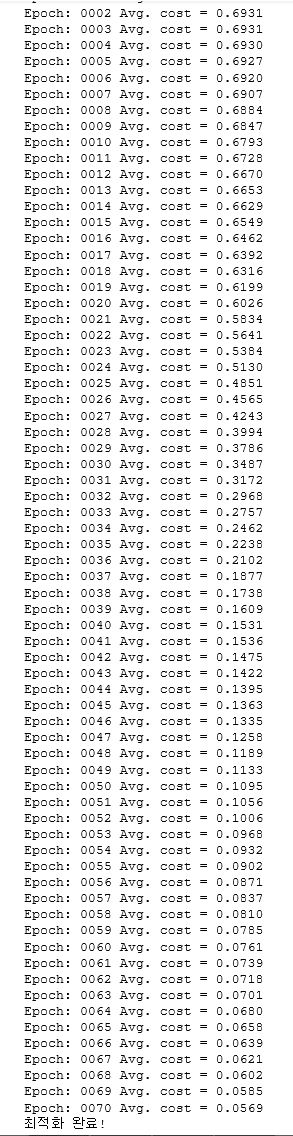

## 모델 검증
## Model validation

In [ ]:
### 이미지2
tr_pred=tf.argmax(model,1)
tr_target=tf.argmax(Y_tr,1)
tr_acc=tf.reduce_mean(tf.cast(tf.equal(tr_pred,tr_target), tf.float32))
print('트레이닝셋 정확도 (training accuracy): %.4f' % sess.run(tr_acc*100, feed_dict={X: X_tr.reshape(-1,256,256,1),
                                                          Y: Y_tr, keep_prob:1}))

tst_pred=tf.argmax(model,1)
tst_target=tf.argmax(Y_tst,1)
tst_acc=tf.reduce_mean(tf.cast(tf.equal(tst_pred,tst_target), tf.float32))
print('테스트셋 예측값 (prediction on test set): %.4f' % sess.run(tst_pred, feed_dict={X: X_tst.reshape(-1,256,256,1),
                                                        keep_prob:1}))

print('실제값 (acutual value):', sess.run(tst_target, feed_dict={Y: Y_tst}))

print('테스트셋 정확도 (test set accuracy): %.4f' % sess.run(tst_acc*100, feed_dict={X: X_tst.reshape(-1,256,256,1),
                                                          Y: Y_tst, keep_prob:1}))

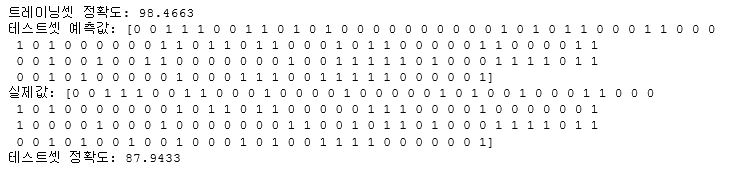

## 실제 데이터 적용
## Entire data applied to the model

In [ ]:
input_path='./DATA/INPUT/주유비 전체/'
output_path='./DATA/TEMP/'

n=np.size(glob.glob(input_path+'*.*'))

# 이미지의 x,y size를 정사각형으로 압축 (256 by 256)
# 임의의 한 데이터로 데이터 저장 배열 크기 알아낸 후, 모든 이미지의 규격이 그와 같다고 가정

# 4:3
# 254 by 237만 쓰는데 나머지는 검은색으로 처리 => 256 by 256
rad_x=24
step_x=9
rad_y=18
step_y=7

X_data_sample=np.zeros(((n,256,256)),dtype=float)
Y_data_sample=np.zeros(((n,2)),dtype=float)

fn_list=[]
fn_except_list=[]
for i in range(n):
    try:
        filename=glob.glob(input_path+'*.*')[i].split('\\')[1]
        fn_list.append(filename.split(',')[0])
        print(i, '파일명: ', input_path+filename)
        raw_data=np.array(convert_to_ela_image(filename,input_path,output_path,90))
        if np.size(raw_data,axis=0)>np.size(raw_data,axis=1):
            x_list=[rad_x+x*step_x for x in range(int((np.size(raw_data,axis=0)-2*rad_x)/step_x))]
            y_list=[rad_y+y*step_y for y in range(int((np.size(raw_data,axis=1)-2*rad_y)/step_y))]
            
            for j,jj in enumerate(x_list):
                for k,kk in enumerate(y_list):
                    X_data_sample[i,j,k]=np.sum(raw_data[jj-rad_x:jj+rad_x+1,kk-rad_y:kk+rad_y+1,:])
            # 0-1 minmax scaling
            X_data_sample[i,:,:]/=np.max(X_data[i,:,:])
        else:
            x_list=[rad_x+x*step_x for x in range(int((np.size(raw_data,axis=1)-2*rad_x)/step_x))]
            y_list=[rad_y+y*step_y for y in range(int((np.size(raw_data,axis=0)-2*rad_y)/step_y))]
            
            for j,jj in enumerate(x_list):
                for k,kk in enumerate(y_list):
                    X_data_sample[i,j,k]=np.sum(raw_data[kk-rad_y:kk+rad_y+1,jj-rad_x:jj+rad_x+1,:])
            # 0-1 minmax scaling
            X_data_sample[i,:,:]/=np.max(X_data[i,:,:])
    except:
        fn_except_list.append(filename.split(',')[0])
        continue

In [ ]:
sample_pred=tf.argmax(model,1)
sample_result=sess.run(sampe_pred, feed_dict={X: X_data_sample.reshape(-1,256,256,1),
                                             keep_prob:1})
sample_result_prob=sess.run(model, feed_dict={X: X_data_sample.reshape(-1,256,256,1),
                                             keep_prob:1})
# sample_result_softmax=np.exp(sample_result_prob)/np.sum(np.exp(sample_result_prob),axis=1).reshape(-1,1)*100

In [ ]:
### 이미지3 => sample_result_softmax 결과 예시

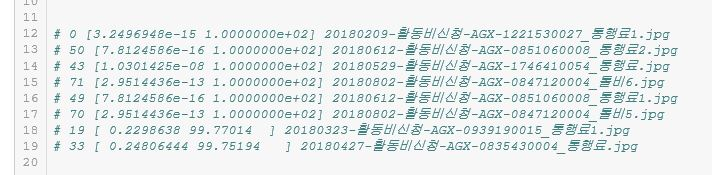